# Install Libraries

In [1]:
!pip install tensorflow pandas numpy sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=3ad94910a07172f0ab9ad5da3a26165c7660ed0f91e3fe22b3dfc4a62ad6a81b
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn


In [2]:
!pip install pandas scikit-learn

In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from keras.layers import SimpleRNN, Dense
import random
import tensorflow as tf
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path_internal = '/content/drive/MyDrive/CKD/Data/AU Raw/eGFR 12-09-2023.xlsx'
file_path_external = '/content/drive/MyDrive/CKD/Data/JP Raw/ROUTE_proteinuria_dataset.xlsx'

# External Data

## 1. Additional Pre-steps

In [1024]:
df = pd.read_excel(file_path_external)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [1025]:
df.dtypes

ID                               int64
gender                           int64
age                              int64
SBP                            float64
BMI                            float64
etiology of CKD                  int64
Hb                             float64
Alb                            float64
Cr                             float64
eGFR                           float64
CKD_stage                        int64
CKD category                   float64
dip-stick proteinuria          float64
proteinuria                    float64
urinary occult blood           float64
UPCR                           float64
UPCR category                  float64
hypertension                     int64
prevalence of CVD                int64
diabetes                         int64
use of RAASi                     int64
use of CCB                       int64
use of diuretics                 int64
eGFR(0M)                       float64
50%eGFR                        float64
eGFR(6M)                 

In [1026]:
df.isna().sum()

ID                               0
gender                           0
age                              0
SBP                             18
BMI                            137
etiology of CKD                  0
Hb                               2
Alb                             12
Cr                               0
eGFR                             0
CKD_stage                        0
CKD category                    88
dip-stick proteinuria           16
proteinuria                     16
urinary occult blood            16
UPCR                            88
UPCR category                   88
hypertension                     0
prevalence of CVD                0
diabetes                         0
use of RAASi                     0
use of CCB                       0
use of diuretics                 0
eGFR(0M)                         0
50%eGFR                          0
eGFR(6M)                       202
50%eGFR_reached(6M)            202
eGFR(12M)                      332
50%eGFR_reached(12M)

In [1027]:
# ID                               0
# gender                           0 ##
# age                              0 ##
# SBP                             18
# BMI                            137
# Hb                               2 #
# Alb                             12 #
# Cr                               0 ##
# eGFR                             0 ##
# dip-stick proteinuria           16
# proteinuria                     16
# urinary occult blood            16
# UPCR                            88 # can it sub UACR?
# UPCR category                   88
# hypertension                     0
# prevalence of CVD                0
# diabetes                         0
# use of RAASi                     0
# use of CCB                       0
# use of diuretics                 0
# HD or PD                       929

In [1028]:
columns_to_flatten = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']

# Use melt to flatten these columns
df_melted = pd.melt(df, id_vars=['ID', 'age', 'gender', 'Cr'], value_vars=columns_to_flatten, var_name='Time', value_name='eGFR')

# Display the melted DataFrame
df_melted

<ipython-input-1028-e904686124c7>:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_melted = pd.melt(df, id_vars=['ID', 'age', 'gender', 'Cr'], value_vars=columns_to_flatten, var_name='Time', value_name='eGFR')


,ID,age,gender,Cr,Time,eGFR
0,10101,74,2,1.20,eGFR(0M),34.146986
1,10102,39,1,1.31,eGFR(0M),50.451187
2,10103,74,1,4.95,eGFR(0M),9.804696
3,10201,57,1,0.84,eGFR(0M),73.570568
4,10202,32,1,0.87,eGFR(0M),83.558305
...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554
9100,160110,62,2,4.74,eGFR(last visit),4.664378
9101,160111,60,1,1.42,eGFR(last visit),41.861876
9102,160112,52,1,2.13,eGFR(last visit),28.931595


In [1029]:
len(set(df_melted['ID']))

1138

In [1030]:
df_melted.isna().sum()

ID           0
age          0
gender       0
Cr           0
Time         0
eGFR      2608
dtype: int64

In [1031]:
import math

def amend_age(row):
    time_str = row['Time']
    months = 0
    if time_str == 'eGFR(6M)':
        months = 6
    elif time_str == 'eGFR(12M)':
        months = 12
    elif time_str == 'eGFR(18M)':
        months = 18
    elif time_str == 'eGFR(24M)':
        months = 24
    elif time_str == 'eGFR(30M)':
        months = 30
    elif time_str == 'eGFR(36M)':
        months = 36
    elif time_str == 'eGFR(last visit)':
        months = 42  # Adding 42 months for 'last visit'

    amended_age = row['age'] + (months / 12.0)

    # Round down the amended age
    return math.floor(amended_age)

# Apply the function to the DataFrame
df_melted['amended_age'] = df_melted.apply(amend_age, axis=1)
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age
0,10101,74,2,1.20,eGFR(0M),34.146986,74
1,10102,39,1,1.31,eGFR(0M),50.451187,39
2,10103,74,1,4.95,eGFR(0M),9.804696,74
3,10201,57,1,0.84,eGFR(0M),73.570568,57
4,10202,32,1,0.87,eGFR(0M),83.558305,32
...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55


In [1032]:
(73.570568/(194*(57**-0.287)))**(-1/1.094)

0.8399999971425922

In [1033]:
import numpy as np

# Assuming df_melted is your DataFrame
def calculate_SCr(row):
    age_factor = row['amended_age'] ** -0.287
    gender_factor = 0.739 if row['gender'] == 2 else 1  # assuming 'female' and 'male' are the gender labels
    eGFR = row['eGFR']

    SCr = ((eGFR / (194 * age_factor * gender_factor)) ** (-1 / 1.094))
    return SCr

# Apply the function to create a new column 'Calculated_SCr'
df_melted['Calculated_SCr'] = df_melted.apply(calculate_SCr, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000
...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000


In [1034]:
df_melted['Cr_umol_per_L'] = df_melted['Calculated_SCr'] * 88.4
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000
...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000


In [1035]:
141 * ((115.804000	* 0.0113 / 0.9) ** -1.209) * ((0.993) ** 39)

68.18759529340964

In [1036]:
# Assuming df_melted is your DataFrame with 'gender', 'age', and 'Cr' columns
def calculate_eGFR_CKD_EPI(row):
    if row['gender'] == 2:
        if row['Cr_umol_per_L'] <= 62:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -0.329) * ((0.993) ** row['amended_age'])
        else:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -1.209) * ((0.993) ** row['amended_age'])
    else:  # Assuming gender is male if not female
        if row['Cr_umol_per_L'] <= 80:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -0.411) * ((0.993) ** row['amended_age'])
        else:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -1.209) * ((0.993) ** row['amended_age'])

# Apply the function to create a new column 'eGFR_CKD_EPI'
df_melted['eGFR_CKD_EPI'] = df_melted.apply(calculate_eGFR_CKD_EPI, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L,eGFR_CKD_EPI
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000,44.685607
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000,68.187595
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000,10.688884
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000,97.237557
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000,114.245526
...,...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322,25.976778
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000,5.061998
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000,54.572415
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000,36.758771


In [1037]:
df_melted.isna().sum()

ID                   0
age                  0
gender               0
Cr                   0
Time                 0
eGFR              2608
amended_age          0
Calculated_SCr    2608
Cr_umol_per_L     2608
eGFR_CKD_EPI      2608
dtype: int64

In [1038]:
df_melted.dropna(subset=['eGFR_CKD_EPI'], inplace=True)

In [1039]:
#df_melted[df_melted['ID'] == 10101]

In [1040]:
# Only Checking Kidney Failure Instances

# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df_melted[df_melted['eGFR_CKD_EPI'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('gender').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 689
Number of female cases where eGFR_CKD_EPI < 15: 394


In [1041]:
# Drop the specified columns
df_melted.drop(['age', 'Cr', 'eGFR', 'Calculated_SCr', 'Cr_umol_per_L'], axis=1, inplace=True)
df_melted

,ID,gender,Time,amended_age,eGFR_CKD_EPI
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


In [1042]:
# Rename columns
df_melted.rename(columns={
    'amended_age': 'AGE',
    'gender': 'SEX',
    'eGFR_CKD_EPI': 'eGFR'
}, inplace=True)

df_melted

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


## 2. Applying Inclusion Criteria

In [1043]:
df = df_melted

In [1044]:
df.dtypes

ID        int64
SEX       int64
Time     object
AGE       int64
eGFR    float64
dtype: object

In [1045]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [1046]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [1047]:
# Sort by date
df.sort_values('ID', inplace=True)

In [1048]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 939


In [1049]:
# Assuming df is your DataFrame
time_order = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']
df['Time'] = pd.Categorical(df['Time'], categories=time_order, ordered=True)

# Sort the DataFrame
df = df.sort_values(['ID', 'Time'])
df

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1138,10101,2,eGFR(6M),74,33.702778
2276,10101,2,eGFR(12M),75,30.641655
3414,10101,2,eGFR(18M),75,31.129969
4552,10101,2,eGFR(24M),76,26.807906
...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304
5688,160112,1,eGFR(24M),54,35.502557
6826,160112,1,eGFR(30M),54,33.338440
7964,160112,1,eGFR(36M),55,36.758771


In [1050]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 597
ID
10101     44.685607
10203     31.094233
10206     45.191558
10208     57.647030
10209     57.791605
            ...    
150403    23.555764
150404    40.630789
160108    30.437540
160111    53.370833
160112    34.579257
Name: eGFR, Length: 597, dtype: float64


In [1051]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 597


In [1052]:
# • Patients who were already on dialysis were excluded, as determined by
# whether their first eGFR reading was taken at a dialysis centre prior
# to their first eGFR reading < 15 #CHECK

In [1053]:
df_copy = df

In [1054]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 369
Number of female cases where eGFR_CKD_EPI < 15: 142


## 3.Kidney Failure Criteria

In [1055]:
patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading (eGFR(0M))
    patient_df = df[(df['ID'] == id) & (df['Time'] != 'eGFR(0M)')]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15]

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:
        patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 162


In [1056]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [1057]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 162
Total number of rows: 983


In [1058]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 365
Number of female cases where eGFR_CKD_EPI < 15: 142


In [1059]:
# # Export data
# df.to_csv('/content/drive/MyDrive/CKD/filtered_data.csv', index=False)

In [1060]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']
# Write the sorted DataFrame to a new CSV file
# subset.to_csv('/content/drive/MyDrive/CKD/filtered_IDs.csv', index=False)

### Further Analysis on Patient IDs with Kidney Failure

In [1061]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

         ID  Number of Records
0     10302                  8
40   150307                  8
29   110213                  8
30   110203                  8
31    90102                  8
..      ...                ...
148   80307                  3
146   20303                  3
145  140108                  3
144   90301                  3
161   80714                  3

[162 rows x 2 columns]


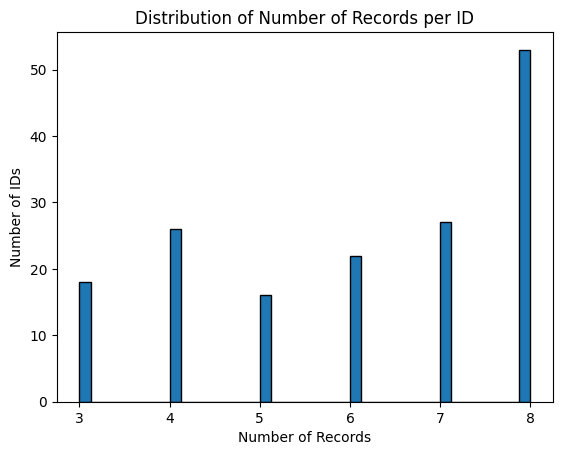

In [1062]:
import matplotlib.pyplot as plt

# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

## 4.Obtain Final Dataframe with the added Kidney Failure Target Variable

In [1063]:
df = df_copy

In [1064]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df

<ipython-input-1064-1f82612d3dba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)


,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [1065]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3930
Total number of unique ids with KF: 162
Total number of rows with KF: 983


In [1066]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df[df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


In [1067]:
df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [1068]:
#df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df.isna().sum()

ID                0
SEX               0
Time              0
AGE               0
eGFR              0
Kidney_Failure    0
dtype: int64

In [1069]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [1070]:
TEST_df = df.copy()
TEST_df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [1071]:
# STATS
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3388
Total number of unique ids with KF: 162
Total number of rows with KF: 456


In [1072]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df[df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


# Internal Data

## 2. Applying Inclusion Criteria

In [1108]:
df = pd.read_excel(file_path_internal)

In [1109]:
df.dtypes

COLLECTED               datetime64[ns]
ID                               int64
SEX                             object
AGE                              int64
INPATIENT/OUTPATIENT            object
eGFR                            object
dtype: object

In [1110]:
# Replace '> 90' with 91 and convert to integer
print(set(df['eGFR']))
df['eGFR'] = np.where(df['eGFR'].str.strip() == "> 90", 91, df['eGFR']).astype(int)
print("Total number of unique ids:", len(df['ID'].unique()))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, '> 90   '}
Total number of unique ids: 149491


In [1111]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 149491


In [1112]:
# Sort by date
df.sort_values('COLLECTED', inplace=True)

In [1113]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 56632


In [1114]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 10072
ID
2         23
7         53
10        54
14        48
19        29
          ..
149209    36
149248    46
149264    57
149302    53
149311    55
Name: eGFR, Length: 10072, dtype: int64


In [1115]:
# Patients who had two eGFR readings on the same day after their first eGFR reading < 15 were considered to be on dialysis and excluded

# Group the data by 'ID' and get the date when the first eGFR < 15 for each patient
first_low_egfr_date = df[df['eGFR'] < 15].groupby('ID')['COLLECTED'].min()

# Join the dates of first low eGFR readings to the original DataFrame
df = df.join(first_low_egfr_date.rename('first_low_egfr_date'), on='ID')

# Only keep rows where 'Date' is after the 'first_low_egfr_date'
df_after_first_low_egfr = df[df['COLLECTED'] > df['first_low_egfr_date']]

# Identify patients who have 2 or more readings on any day after their first eGFR reading < 15
patients_on_dialysis = df_after_first_low_egfr.groupby(['ID', 'COLLECTED']).filter(lambda x: len(x) >= 2)['ID'].unique()

# Filter these patients out from the original DataFrame
df = df[~df['ID'].isin(patients_on_dialysis)]

df.drop('first_low_egfr_date', axis=1, inplace=True)

print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 10064


<ipython-input-1115-16f5475cab17>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('first_low_egfr_date', axis=1, inplace=True)


In [1116]:
# • Patients who were already on dialysis were excluded, as determined by
# whether their first eGFR reading was taken at a dialysis centre prior
# to their first eGFR reading < 15 #CHECK

In [1117]:
df_copy = df

## 3. Kidney Failure Criteria

In [1118]:
# Kidney failure was determined as follows: UIDs with two eGFR readings < 15 at least 30 days apart, with one eGFR reading > 15 immediately preceding these.
# This eliminates cases where patients are already in kidney failure — only patients that progress from CKD to kidney failure are included.

import itertools

patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading
    patient_df = df[df['ID'] == id]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15].sort_values(by='COLLECTED')

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:

        # Loop through the data and find if there are any two dates at least 90 days apart
        found_90_days_apart = False
        for date1, date2 in itertools.combinations(low_eGFR['COLLECTED'], 2):
            time_diff = (date2 - date1).days

            # If time difference is at least 90 days, set the flag to True and break
            if time_diff >= 30: #90  #355 patients at 29 days
                found_90_days_apart = True
                break

        if found_90_days_apart:
            patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 353


In [1119]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [1120]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 353
Total number of rows: 23711


In [1121]:
# Export data
#df.to_csv('/content/drive/MyDrive/CKD/filtered_internal_data.csv', index=False)

In [1122]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']
# Write the sorted DataFrame to a new CSV file
#subset.to_csv('/content/drive/MyDrive/CKD/filtered_internal_IDs.csv', index=False)

### Further Analysis on Patient IDs with Kidney Failure

In [1123]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

        ID  Number of Records
0     7516                350
1       75                310
2    10214                217
3    46650                210
4    35687                209
..     ...                ...
348   9265                  8
349  38291                  5
350  49461                  4
351  35069                  4
352  30131                  3

[353 rows x 2 columns]


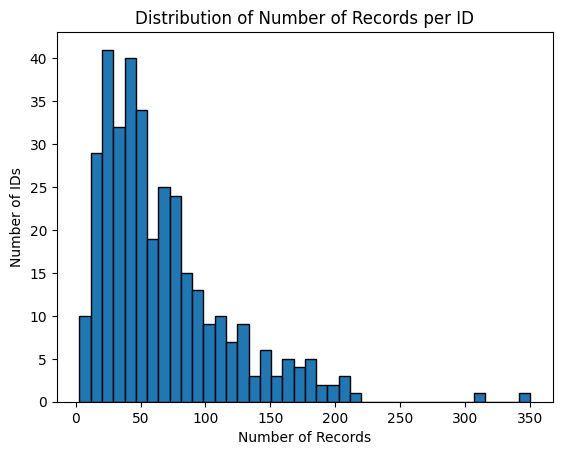

In [1124]:
import matplotlib.pyplot as plt

# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

In [1125]:
# Group by 'ID' and 'COLLECTED_DATE', and count the number of records in each group
same_day_readings = df.groupby(['ID', 'COLLECTED']).size()

# Find out which IDs had multiple readings on the same day
multiple_same_day_readings = same_day_readings[same_day_readings > 1]

# Print the result
print(multiple_same_day_readings)

ID     COLLECTED          
574    2020-07-14 11:40:00    2
14971  2020-08-11 11:22:00    2
dtype: int64


In [1126]:
# Group by 'ID' and find the first 'COLLECTED_DATE' for each group
first_reading_dates = df.groupby('ID')['COLLECTED'].min().reset_index()

# Rename the columns for the join operation
first_reading_dates.columns = ['ID', 'FIRST_READING_DATE']

# Join 'multiple_same_day_readings' with 'first_reading_dates' on 'ID' and 'COLLECTED_DATE'
merged_df = pd.merge(multiple_same_day_readings.reset_index(), first_reading_dates, how='left', left_on=['ID', 'COLLECTED'], right_on=['ID', 'FIRST_READING_DATE'])

# Find out how many of the multiple-reading days were the first day of readings
first_day_multiple_readings = merged_df[merged_df['COLLECTED'] == merged_df['FIRST_READING_DATE']]

# Print the result
print(first_day_multiple_readings)

Empty DataFrame
Columns: [ID, COLLECTED, 0, FIRST_READING_DATE]
Index: []


## 4. Obtain Final Dataframe with the added Kidney Failure Target Variable

In [1127]:
df = df_copy

In [1128]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
6,2019-01-07 23:05:00,7,M,69,INPATIENT,53,0
9,2019-01-07 23:23:00,10,F,83,INPATIENT,54,0
13,2019-01-07 23:37:00,14,F,65,INPATIENT,48,0
18,2019-01-08 00:10:00,19,M,83,INPATIENT,29,0
...,...,...,...,...,...,...,...
762755,2023-03-31 19:30:00,86286,M,67,INPATIENT,21,0
762763,2023-03-31 20:18:00,7366,M,79,INPATIENT,33,0
762769,2023-03-31 20:33:00,10774,F,56,INPATIENT,85,0
762776,2023-03-31 21:09:00,43998,F,85,INPATIENT,38,0


In [1129]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 10064
Total number of rows: 183600
Total number of unique ids with KF: 353
Total number of rows with KF: 23711


In [1130]:
df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [1131]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [1132]:
df_merged = df

# Convert 'COLLECTED' to datetime and sort the dataframe by 'ID' and 'COLLECTED'
df_merged['COLLECTED'] = pd.to_datetime(df_merged['COLLECTED'])
df_merged.sort_values(['ID', 'COLLECTED'], inplace=True)

# Encode 'SEX' as 2 for female and 1 for male
df_merged['SEX'] = df_merged['SEX'].replace({'F': 2, 'M': 1})

# Drop extraneous columns
df_merged = df_merged.drop(columns=['INPATIENT/OUTPATIENT'])

print("Total number of unique ids:", len(df_merged['ID'].unique()))
print(f"Total number of rows: {len(df_merged)}")
print("Total number of unique ids with KF:", len(df_merged[df_merged['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df_merged[df_merged['Kidney_Failure']==1])}")

<ipython-input-1132-835afeb23572>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['COLLECTED'] = pd.to_datetime(df_merged['COLLECTED'])
<ipython-input-1132-835afeb23572>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged.sort_values(['ID', 'COLLECTED'], inplace=True)
<ipython-input-1132-835afeb23572>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Total number of unique ids: 10064
Total number of rows: 154516
Total number of unique ids with KF: 353
Total number of rows with KF: 5543


In [1133]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df_merged[df_merged['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 216
Number of unique female cases of kidney failure: 137


# Train and Evaluate Models

### TUNED HYPERAMETER MODEL - AU Dataset

In [1134]:
# Normalize the numeric columns
scaler = MinMaxScaler()
df_merged[['AGE', 'eGFR']] = scaler.fit_transform(df_merged[['AGE', 'eGFR']])

# Filter UIDs with sequences >= 3
grouped = df_merged.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED']  # add other non-numeric columns if present

X = pad_sequences(df_merged.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = df_merged.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}

In [855]:
# # The previous code varied the random initialization of the model, but kept the training and testing sets the same
# # Now we will vary the training and testing sets
# # Because we will be using the same model, we will not need to train longer, which we can do because we had a hint of convergence after 1000 epochs

# import numpy as np
# import pandas as pd
# from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense
# from keras.metrics import Precision, Recall
# import random
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
# from sklearn.model_selection import train_test_split

# # Adjust this threshold as needed
# threshold = 0.5

# # Create an empty dictionary to store ensemble components as well as their test statistics
# ensemble = {}
# # Do 10 runs of the model, and store the results in a dataframe

# # Create a dataframe to store the results

# df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'TPR', 'TNR', 'FPR', 'FNR', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'ROC-AUC'])

# # Create an empty DataFrame to store the results
# df_error_seq = pd.DataFrame(columns=['Run','Epoch', 'Training Loss', 'Test Loss', 'Error Difference'])

# # Here we are varying the training and testing sets
# for seed_value in range(10):

#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     tf.random.set_seed(0) # Fix initial random weights of the model - always use the same initial weights

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed_value, stratify=y)

#     # Split the data (X_total, y_total) into training and test sets
#     # Define the model
#     model = Sequential()
#     model.add(SimpleRNN(units=4, input_shape=(50, 3), return_sequences=False))
#     #model.add(SimpleRNN(units=1))
#     model.add(Dense(1, activation = 'sigmoid')) # This is just a linear combination

#     # Compile the model
#     precision = Precision(thresholds=threshold)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, Recall()]) #CHECK!

#     # Fit the model
#     #model.fit(X_train, y_train, epochs=1000, batch_size=128)

#     # Lists to store training and test losses
#     train_losses = []
#     test_losses = []

#     # Fit the model #CHECK
#     epochs = 50
#     for epoch in range(epochs):
#         # Train the model for one epoch
#         history = model.fit(X_train, y_train, epochs=1, batch_size=128, verbose=0, class_weight=class_weights)

#         # Use this code if not balancing class weights
#         # history = model.fit(X_train, y_train, epochs=1, batch_size=128, verbose=0)

#         # Compute training loss for the current epoch
#         train_loss = history.history['loss'][0]
#         train_losses.append(train_loss)

#         # Evaluate the model on the test set
#         test_loss = model.evaluate(X_test, y_test, verbose=0)[0]
#         test_losses.append(test_loss)

#         # Print the training and test errors every hundred epochs
#         if (epoch + 1) % 100 == 0:
#             error_difference = train_loss - test_loss
#             df_error_seq = pd.concat([df_error_seq, pd.DataFrame({'Run':seed_value,
#                                                                   'Epoch': epoch+1,
#                                                                   'Training Loss': train_loss,
#                                                                   'Test Loss': test_loss,
#                                                                   'Error Difference': error_difference},
#                                                                   index=[seed_value])])

#     # Evaluate the model on the test set
#     loss = model.evaluate(X_test, y_test)

#     # Make predictions
#     predictions = model.predict(X_test)

#     # Apply threshold
#     predicted_labels = (predictions >= threshold).astype(int)

#     # Given predicted labels, print the number of true positives, true negatives, false positives and false negatives
#     # Create a dataframe with the predicted labels and the true labels
#     df_predicted_labels = pd.DataFrame({'Predicted': predicted_labels.flatten(), 'True': y_test.flatten()})

#     # Compute the number of true positives, true negatives, false positives and false negatives, and other statistics
#     true_positives = len(df_predicted_labels[(df_predicted_labels['Predicted'] == 1) & (df_predicted_labels['True'] == 1)])
#     true_negatives = len(df_predicted_labels[(df_predicted_labels['Predicted'] == 0) & (df_predicted_labels['True'] == 0)])
#     false_positives = len(df_predicted_labels[(df_predicted_labels['Predicted'] == 1) & (df_predicted_labels['True'] == 0)])
#     false_negatives = len(df_predicted_labels[(df_predicted_labels['Predicted'] == 0) & (df_predicted_labels['True'] == 1)])
#     tpr = true_positives / (true_positives + false_negatives + 1)
#     tnr = true_negatives / (true_negatives + false_positives + 1)
#     fpr = false_positives / (false_positives + true_negatives + 1)
#     fnr = false_negatives / (false_negatives + true_positives + 1)
#     accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
#     precision = true_positives / (true_positives + false_positives + 1)
#     recall = true_positives / (true_positives + false_negatives + 1)
#     specificity = true_negatives / (true_negatives + false_positives + 1)
#     roc_auc = roc_auc_score(y_test, predictions)
#     print(accuracy, precision, recall, specificity, roc_auc)

#     # Add the statistics to the dataframe
#     df_results.loc[seed_value] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, specificity, roc_auc]

#     # Add the model to the ensemble, along with its test statistics
#     ensemble[seed_value] = {'model': model,
#                             'test_statistics': {'true_positives': true_positives,
#                                                 'true_negatives': true_negatives,
#                                                 'false_positives': false_positives,
#                                                 'false_negatives': false_negatives,
#                                                 'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
#                                                 'accuracy': accuracy,
#                                                 'precision': precision,
#                                                 'recall': recall,
#                                                 'specificity': specificity,
#                                                 'roc_auc': roc_auc}}

# # Print the average of each statistic over the 10 runs in one line
# print(df_results.mean())

158/158 [==============================] - 1s 6ms/step
0.6647456279809221 0.08415841584158416 0.864406779661017 0.6571957998764669 0.8210262374569417
158/158 [==============================] - 1s 4ms/step
0.7639109697933227 0.11314984709480122 0.8314606741573034 0.7611202635914333 0.8626368063677147
158/158 [==============================] - 1s 4ms/step
0.7255564387917329 0.1038107752956636 0.8926553672316384 0.7191682108297303 0.8408149009660026
158/158 [==============================] - 1s 4ms/step
0.9306438791732909 0.29285714285714287 0.6949152542372882 0.938851142680667 0.9057392681967951
158/158 [==============================] - 1s 6ms/step
0.7974960254372019 0.12522202486678508 0.7966101694915254 0.7971999176446366 0.8544970140032949
158/158 [==============================] - 1s 4ms/step
0.7609300476947536 0.10590943975441289 0.7752808988764045 0.7600906095551895 0.7947471009559717
158/158 [==============================] - 1s 6ms/step
0.9268680445151033 0.14909090909090908 0.2

In [83]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
# from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense
# from keras.optimizers import Adam
# from scikeras.wrappers import KerasClassifier, KerasRegressor

# # Set random seeds
# seed_value = 3
# np.random.seed(seed_value)

# # Adjust this threshold as needed
# threshold = 0.5

# # Create a dataframe to store the results
# df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
#                                    'TPR', 'TNR', 'FPR', 'FNR',
#                                    'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# # Function to create the model, required for KerasClassifier
# def create_model(lr=0.001):
#     # Create model
#     model = Sequential()
#     model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False))
#     model.add(Dense(1, activation='sigmoid'))
#     optimizer = Adam(learning_rate=lr)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=Precision())
#     return model

# # Create the KerasClassifier
# model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, lr=0.001, verbose=1)

# # Define the grid search parameters
# param_grid = {
#     #'epochs': [10, 50],
#     #'batch_size': [32, 128],
#     'model__lr': [0.001, 0.01, 0.1] # Prefix with 'model__' to denote it's a parameter for the model-building function
# }

# #grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', n_jobs=-1, cv=3)

# grid_result = grid.fit(X, y)

# # Output the best parameters and score
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
79/79 [==============================] - 2s 10ms/step - loss: 0.4089 - precision: 0.0000e+00
Epoch 2/20
79/79 [==============================] - 1s 9ms/step - loss: 0.2834 - precision: 0.0000e+00
Epoch 3/20
79/79 [==============================] - 1s 14ms/step - loss: 0.2254 - precision: 0.0000e+00
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1930 - precision: 0.0000e+00
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1748 - precision: 0.0000e+00
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.1646 - precision: 0.0000e+00
Epoch 7/20
79/79 [==============================] - 1s 13ms/step - loss: 0.1590 - precision: 0.0000e+00
Epoch 8/20
79/79 [==============================] - 1s 9ms/step - loss: 0.1558 - precision: 0.0000e+00
Epoch 9/20
79/79 [==============================] - 1s 9ms/step - loss: 0.1540 - precision: 0.0000e+00
Epoch 10/20
79/79 [==============================] - 1s 9ms/step - 

In [1135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# Set random seeds
seed_value = 3
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Use Stratified KFold for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the model
    model = Sequential()
    model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False)) #50, 4 !CHECK
    model.add(Dense(1, activation = 'sigmoid')) # This is just a linear combination

    # Compile the model
    precision = Precision(thresholds=threshold)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision])

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=128, class_weight=class_weights)
    print(class_weights)

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test)

    # Get the predictions
    predictions = model.predict(X_test)
    predicted_labels = (predictions >= threshold).astype(int).flatten()

    # Compute the statistics
    true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
    true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
    false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
    false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = (true_positives + true_negatives) / len(y_test)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = 2 * precision * recall / (precision + recall)
    specificity = true_negatives / (true_negatives + false_positives)
    roc_auc = roc_auc_score(y_test, predictions)

    print(accuracy, precision, recall, f1, specificity, roc_auc)

    # Add the statistics to the dataframe
    df_results.loc[len(df_results)] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, f1, specificity, roc_auc]

# Print the average of each statistic over the 5 folds
print(df_results.mean())

Epoch 1/50
63/63 [==============================] - 2s 10ms/step - loss: 1.4231 - precision_93: 0.0506
Epoch 2/50
63/63 [==============================] - 1s 10ms/step - loss: 1.4025 - precision_93: 0.0443
Epoch 3/50
63/63 [==============================] - 1s 10ms/step - loss: 1.3914 - precision_93: 0.0498
Epoch 4/50
63/63 [==============================] - 1s 10ms/step - loss: 1.3813 - precision_93: 0.0538
Epoch 5/50
63/63 [==============================] - 1s 10ms/step - loss: 1.3745 - precision_93: 0.0487
Epoch 6/50
63/63 [==============================] - 1s 13ms/step - loss: 1.3598 - precision_93: 0.0505
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 1.3452 - precision_93: 0.0493
Epoch 8/50
63/63 [==============================] - 1s 18ms/step - loss: 1.3332 - precision_93: 0.0506
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 1.3282 - precision_93: 0.0511
Epoch 10/50
63/63 [==============================] - 1s 17ms/step - loss:

In [1104]:
# Train the final model on the full Australian dataset

import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.metrics import Precision

# Set random seeds for reproducibility
seed_value = 3
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Define the RNN model for the entire dataset
model = Sequential()
model.add(SimpleRNN(units=3, input_shape=(50, 3), return_sequences=False))
model.add(Dense(1, activation='sigmoid')) # This is a binary classification output

# Compile the model
precision = Precision(thresholds=threshold)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision])

# Fit the model on the entire dataset
model.fit(X, y, epochs=50, batch_size=128, class_weight=class_weights)

Epoch 1/50
79/79 [==============================] - 3s 16ms/step - loss: 1.4231 - precision_92: 0.0418
Epoch 2/50
79/79 [==============================] - 1s 16ms/step - loss: 1.4042 - precision_92: 0.0493
Epoch 3/50
79/79 [==============================] - 1s 14ms/step - loss: 1.3894 - precision_92: 0.0484
Epoch 4/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3688 - precision_92: 0.0501
Epoch 5/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3484 - precision_92: 0.0498
Epoch 6/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3345 - precision_92: 0.0534
Epoch 7/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3188 - precision_92: 0.0553
Epoch 8/50
79/79 [==============================] - 1s 9ms/step - loss: 1.3127 - precision_92: 0.0546
Epoch 9/50
79/79 [==============================] - 1s 10ms/step - loss: 1.3096 - precision_92: 0.0546
Epoch 10/50
79/79 [==============================] - 1s 9ms/step - loss: 1.299

### HELD-OUT TEST DATA - Tuned Model (Without Fine-Tuning)

In [1105]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

TEST_df = TEST_df.reset_index(drop=True)

# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Apply the function to the 'Time' column to create a new 'Months' column
TEST_df['Months'] = TEST_df['Time'].apply(convert_to_months)

# Assume a starting date for all IDs
start_date = pd.Timestamp('2020-01-01')

# Create a 'COLLECTED' column based on the 'Months' column
TEST_df['COLLECTED'] = TEST_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

#TEST_df.drop(['Time', 'Months'], inplace = True)

# Normalize the numeric columns
scaler = MinMaxScaler()
TEST_df[['AGE', 'eGFR']] = scaler.fit_transform(TEST_df[['AGE', 'eGFR']])

In [1106]:
# Filter UIDs with sequences >= 3
grouped = TEST_df.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED', 'Time', 'Months']  # add other non-numeric columns if present

X = pad_sequences(TEST_df.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = TEST_df.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}

In [1107]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import random

# Set random seeds
seed_value = 3
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Evaluate on the held-out test set
#clf = best_clf

# Evaluate the model on the test set
# loss = model.evaluate(X, y)

y_pred = model.predict(X)

predicted_labels = (y_pred >= threshold).astype(int).flatten()

# Compute the statistics
true_positives = np.sum((predicted_labels == 1) & (y == 1))
true_negatives = np.sum((predicted_labels == 0) & (y == 0))
false_positives = np.sum((predicted_labels == 1) & (y == 0))
false_negatives = np.sum((predicted_labels == 0) & (y == 1))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = (true_positives + true_negatives) / len(y)
precision = precision_score(y, predicted_labels)
recall = recall_score(y, predicted_labels)
f1 = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y, predicted_labels)
#roc_auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

print(accuracy, precision, recall, f1, specificity, roc_auc)

print("TPR:", tpr, "TNR:", tnr, "FPR:", fpr, "FNR:", fnr,
      '\n' "Accuracy", accuracy, "Precision:", precision, "Recall:", recall, "F1 Score:", f1, "Specificity:", specificity, "ROC-AUC:", roc_auc)

19/19 [==============================] - 0s 5ms/step
0.6817420435510888 0.4590643274853801 0.9691358024691358 0.623015873015873 0.5747126436781609 0.7719242230736483
TPR: 0.9691358024691358 TNR: 0.5747126436781609 FPR: 0.42528735632183906 FNR: 0.030864197530864196 
Accuracy 0.6817420435510888 Precision: 0.4590643274853801 Recall: 0.9691358024691358 F1 Score: 0.623015873015873 Specificity: 0.5747126436781609 ROC-AUC: 0.7719242230736483


### HELD-OUT TEST DATA - Tuned Model (with Fine Tuning)

In [1073]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

TEST_df = TEST_df.reset_index(drop=True)

# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Apply the function to the 'Time' column to create a new 'Months' column
TEST_df['Months'] = TEST_df['Time'].apply(convert_to_months)

# Assume a starting date for all IDs
start_date = pd.Timestamp('2020-01-01')

# Create a 'COLLECTED' column based on the 'Months' column
TEST_df['COLLECTED'] = TEST_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)

#TEST_df.drop(['Time', 'Months'], inplace = True)

# Normalize the numeric columns
scaler = MinMaxScaler()
TEST_df[['AGE', 'eGFR']] = scaler.fit_transform(TEST_df[['AGE', 'eGFR']])


In [1074]:
# Filter UIDs with sequences >= 3
grouped = TEST_df.groupby(['ID', 'Kidney_Failure']).size().unstack(fill_value=0)
grouped = grouped[(grouped[1] >= 0) | (grouped[0] >= 0)] #3

# List of columns to drop
cols_to_drop = ['ID', 'Kidney_Failure', 'COLLECTED', 'Time', 'Months']  # add other non-numeric columns if present

X = pad_sequences(TEST_df.groupby('ID').apply(lambda group: group.drop(cols_to_drop, axis=1).to_numpy()).tolist(), maxlen=50, dtype='float32', padding='post')
y = TEST_df.groupby('ID')['Kidney_Failure'].first().to_numpy()

# Initialise class weights
class_counts = np.bincount(y)
total_samples = np.sum(class_counts)
class_weights = {0: total_samples / (class_counts[0] + 1), 1: total_samples / (class_counts[1] + 1)}

In [1075]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import random
from sklearn import metrics
import matplotlib.pyplot as plt

# Set random seeds
seed_value = 3
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Train the model on 15% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=seed_value, stratify=y)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predicted_labels = (y_pred >= threshold).astype(int).flatten()

# Compute the statistics
true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = (true_positives + true_negatives) / len(y_test)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, predicted_labels)

print(accuracy, precision, recall, f1, specificity, roc_auc)

print("TPR:", tpr, "TNR:", tnr, "FPR:", fpr, "FNR:", fnr,
      '\n' "Accuracy", accuracy, "Precision:", precision, "Recall:", recall, "F1 Score:", f1, "Specificity:", specificity, "ROC-AUC:", roc_auc)

16/16 [==============================] - 0s 6ms/step
0.6811023622047244 0.4586206896551724 0.9637681159420289 0.6214953271028036 0.5756756756756757 0.7697218958088523
TPR: 0.9637681159420289 TNR: 0.5756756756756757 FPR: 0.4243243243243243 FNR: 0.036231884057971016 
Accuracy 0.6811023622047244 Precision: 0.4586206896551724 Recall: 0.9637681159420289 F1 Score: 0.6214953271028036 Specificity: 0.5756756756756757 ROC-AUC: 0.7697218958088523
